In [760]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os as os

#ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [761]:
def preprocessing(df):  

    #drop duplicated columns
    drop_column=['description2', 'Unnamed: 0', 'link', 'author_y', 'title','url', 'title_1']
    df=df.drop(drop_column,axis=1)
    
    #renaming
    column_names=['author', 'date_recorded', 'views', 'likes', 'title',
       'description_1', 'duration_seg', 'date_released', 'keywords','description_2']
    df.columns=column_names

    #
    #MODIFYING COLUMN: date_recorded
    #
    df['date_recorded']= pd.to_datetime(df['date_recorded'], format='%B %Y')
  
    ##separate data into new Column
    list_months=[]
    list_years=[]
    for i in range(df.shape[0]):
        list_months.append(df['date_recorded'][i].month)
        list_years.append(df['date_recorded'][i].year)
    df['date_recorded_year']=list_years
    df['date_recorded_month']=list_months

    #
    #MODIFYING COLUMN: date_released
    #
    column='date_released'
    df[column]= pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')

    ##separate data into new Column
    list_months=[]
    list_years=[]
    list_hours=[]
    list_minutes=[]
    for i in range(df.shape[0]):
        list_months.append(df[column][i].month)
        list_years.append(df[column][i].year)
        list_hours.append(df[column][i].hour)
        list_minutes.append(df[column][i].minute)
    df[column+'_year']=list_years
    df[column+'_month']=list_months
    df[column+'_hour']=list_hours
    df[column+'_minute']=list_minutes

    #
    #MODIFYING COLUMN: 'keywords'
    #
    df_key=df.keywords
    i=0
    df_result=pd.DataFrame()
    ##transforming line into string
    for line in df_key:
        line=(str(line).replace("[","").replace("]","").split(','))
        new_line=[]
        ##removing additional spaces in words and converting the into lower case
        for word in line:
            word=word.lower().replace(' ', '')[1:-1]
            new_line.append(word)
        ##transforming line into string
        new_line=str(new_line).replace("[","").replace("]","")
        ##writting line into dataframe
        df_result.at[i,'keywords2']=new_line
        i=i+1
  
    df=pd.concat([df,df_result], axis=1)

    #drop initial columns
    drop_columns=['date_recorded','date_released', 'keywords']
    df=df.drop(drop_columns, axis=1)
    
    return(df)

In [762]:
def create_dummies_file(df):
    '''
    This function does: 
    1) convert df.keywords into dummy columns
    2) creates a file called ''in order to manually map new categories from keywords
    '''
    #converting keywords into dummy columns
    df2=df.keywords2.str.get_dummies(',')

    #joining with df
    df=pd.concat([df,df2], axis=1)
    
    #removing 'ted' column
    column_to_drop=df.columns[362]
    df2=df.drop(column_to_drop, axis=1)

    #counting dummies and creating file to rename categories
    dummy_columns=pd.Series(np.arange(15,349,1))[1:]
    df_dummies=df.iloc[:,dummy_columns].sum().reset_index()
    df_dummies.columns=['keyword', 'sum']
    df2=df_dummies.copy()
    (df2
     .pipe(lambda df2: pd.crosstab(df2.keyword, df2.sum))
    )
    df2=df2.sort_values(by='sum', ascending=False)
    cwd=os.getcwd()
    df2.to_csv(cwd+'/keywords.csv')
    return df

In [763]:
def dummy_data(df):
    '''
    This function takes the keyword_categories.csv file and creates a new dataframe 'df_dummies' to analyze the keywords
    '''
    cwd=os.getcwd()
    categories=pd.read_csv(cwd+'/keywords_categories.csv')

    #transforming categories
    new_cat=(categories.columns.values.tolist())
    dic={key: None for key in new_cat}

    ##creating dictionary with categories file
    for column in range (0,categories.shape[1]):
        dic_values=[]
        key=new_cat[column]
        for row in range (0,categories.shape[0]):
            value=categories.iloc[row,column]
            if value is np.nan:
                pass
            else:
                value=value.replace(' ', '')[1:-1]
                dic_values.append(value)
        dic.update({key:dic_values})

    ##adding column to df with 
    dummy_columns=pd.Series(np.arange(15,349,1))[1:]
    df_dummies=df.iloc[:,dummy_columns].sum().reset_index()
    list_categories=[]
    for i in range (0, len(set(df_dummies['index']))):
        keyword=df_dummies['index'][i][2:-1]
        ###find category of keyword in dictionary
        for key, value_list in dic.items():
            for x in value_list:
                if keyword==x:
                    category=key
        ###add category to list
        list_categories.append(category)
    ##add list_categories to df
    df_dummies['new_category']=list_categories
    df_dummies.columns=['keywords', 'sum', 'categories']
    df_dummies=df_dummies[['categories','keywords', 'sum']]
    return df_dummies

In [764]:
def main():
    #load data
    raw_data=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/1_raw_data/final_raw_data.csv')
    df=raw_data.copy()

    #clean data
    df=preprocessing(df)
    df=create_dummies_file(df)
    df_dummies=dummy_data(df)
    return(df, df_dummies)
  


In [765]:
if __name__ == '__main__':
  main()

In [766]:
df.shape

(5440, 363)

In [767]:
df=main()[0]
df.head(5)

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,404000,12000,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,214000,6400,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,412000,12000,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",2021,9,2022,...,0,0,0,0,0,1,0,0,0,1
3,James K. Thornton,427000,12000,Why is China appointing judges to combat clima...,"""Why is China appointing thousands of judges t...",695,"""Why is China appointing thousands of judges t...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1
4,Mahendra Singhi,2400,72,Cement's carbon problem -- and 2 ways to fix it,"""Cement is vital to modernizing all kinds of i...",671,"""Cement is vital to modernizing all kinds of i...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1


In [768]:
df_dummies=main()[1]
df_dummies.head(5)

,categories,keywords,sum
0,technology,'3dprinting',9
1,values & emotions,'activism',352
2,health,'addiction',20
3,global,'africa',197
4,society,'aging',93


# Data Exploration

In [769]:
# missing data
((df
 .isna()
 .mean()
 *100)
 .pipe(lambda ser:ser[ser>0])
)

author    0.018382
dtype: float64

In [770]:
df.head(5)

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,404000,12000,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,214000,6400,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,412000,12000,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",2021,9,2022,...,0,0,0,0,0,1,0,0,0,1
3,James K. Thornton,427000,12000,Why is China appointing judges to combat clima...,"""Why is China appointing thousands of judges t...",695,"""Why is China appointing thousands of judges t...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1
4,Mahendra Singhi,2400,72,Cement's carbon problem -- and 2 ways to fix it,"""Cement is vital to modernizing all kinds of i...",671,"""Cement is vital to modernizing all kinds of i...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1


## Exploring: date recorded

<AxesSubplot:>

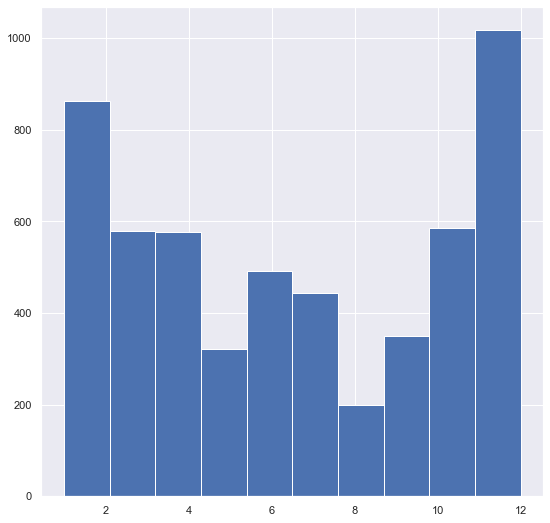

In [771]:
df_graph=df[df.date_recorded_year>2000]
df_graph.date_recorded_month.hist()

<AxesSubplot:>

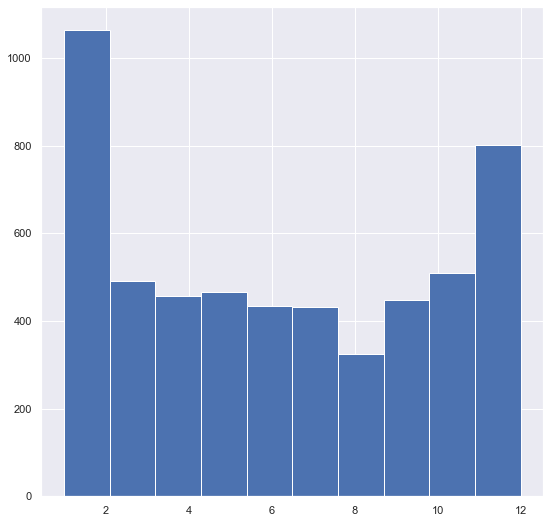

In [772]:
df_graph.date_released_month.hist()

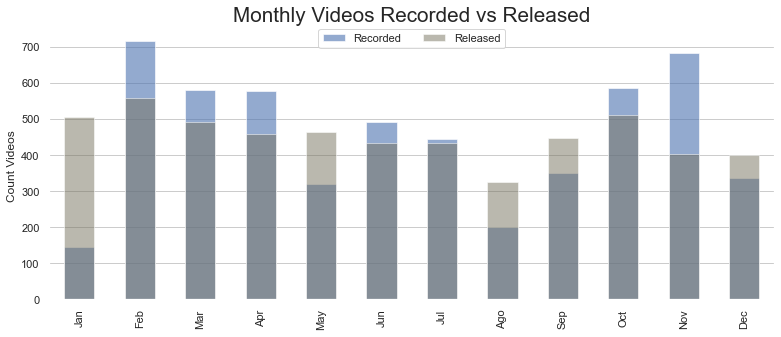

In [773]:
# @hidden_cell
#improving graph

data=df[df.date_recorded_year>2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

#plotting first hidtogram
ax=(data
    .groupby(['date_recorded_month'])
    .likes
    .count()
    .plot(x='date_recorded_month', kind = 'bar',alpha=0.6, ax=ax,) 
)
#plotting second hidtogram
ax=(data
    .groupby(['date_released_month'])
    .likes
    .count()
    .plot(x='date_released_month', kind = 'bar',alpha=0.5, ax=ax, color='#76725e') 
)
#improving labes
ax.set_xticks(ticks=range(0,12,1))  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('Count Videos ')
#styling grid, leyend and title
plt.title('Monthly Videos Recorded vs Released', ha='center', fontsize='xx-large')
plt.legend(["Recorded", "Released"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

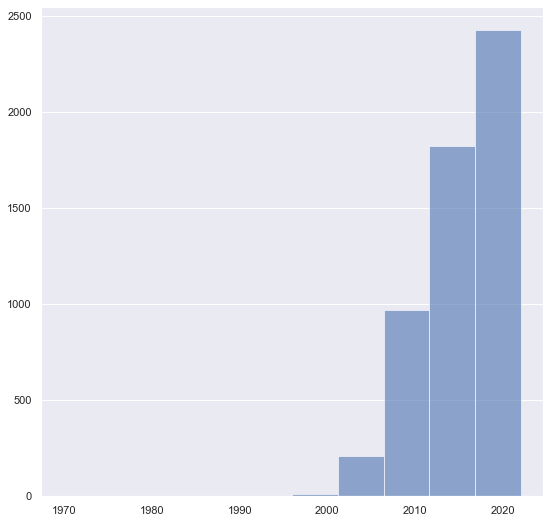

In [774]:
df.date_recorded_year.hist(alpha=0.6)
plt.grid(axis='x')

<AxesSubplot:>

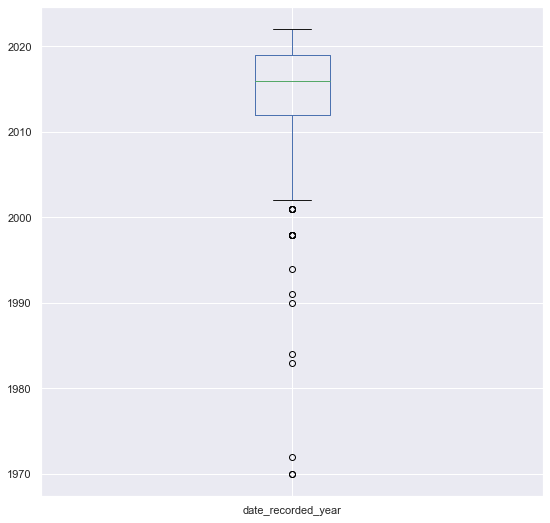

In [775]:
# Are there outliers
df.date_recorded_year.plot.box()

In [776]:
df_graph=df[df.date_recorded_year<2000]


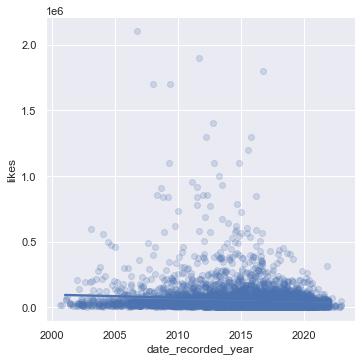

In [777]:
#removing outliyers
df_graph=df[df.date_recorded_year>2000]
sns.lmplot(x='date_recorded_year', y='likes', data=df_graph, x_jitter=1, scatter_kws={'alpha':.2})

## Exploring: duration of videos

<AxesSubplot:>

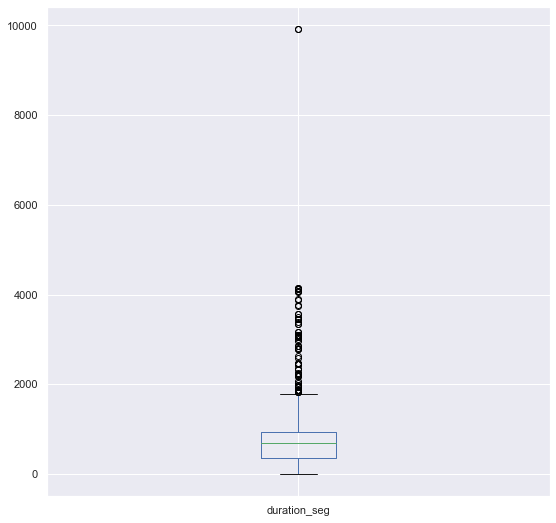

In [778]:
# Are there outliers
df.duration_seg.plot.box()

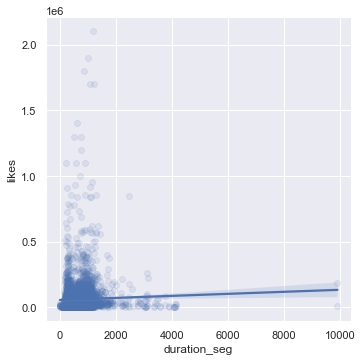

In [779]:
#removing outliyers
df_graph=df[df.date_recorded_year>2000]
sns.lmplot(x='duration_seg', y='likes', data=df_graph, x_jitter=1, scatter_kws={'alpha':.1})

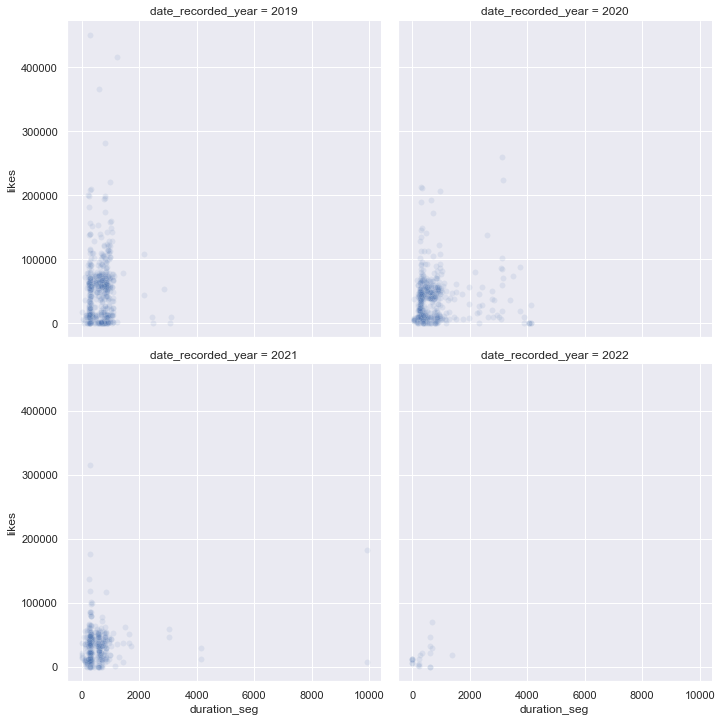

In [780]:
#Insight: during pandemic years (2020-2021) 
df_graph=df[df.date_recorded_year>2018]
sns.relplot(x='duration_seg', y='likes', data=df_graph, col='date_recorded_year', col_wrap=2, alpha=.1)

array([[<AxesSubplot:title={'center':"('likes', 'sum')"}>,
        <AxesSubplot:title={'center':"('views', 'sum')"}>]], dtype=object)

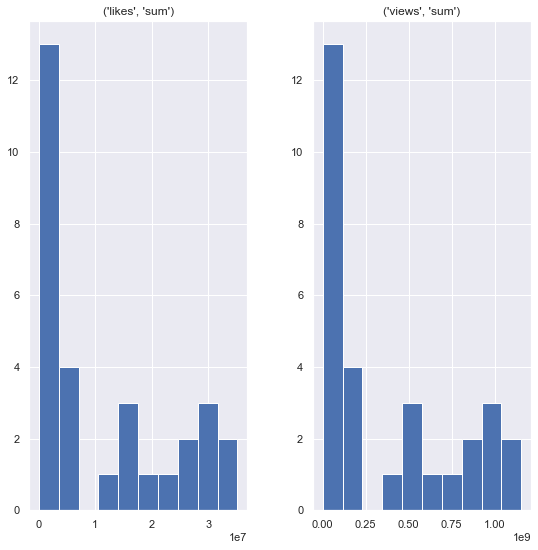

In [781]:
df_graph = pd.pivot_table(data=df, 
               index=['date_recorded_year'], 
               values=['likes','views'], 
               aggfunc={'likes':[np.sum],'views':np.sum}
        )
df_graph.hist()

In [782]:
not_dummy_columns=pd.Series(np.arange(0,14,1))
df_graph=df.iloc[:,not_dummy_columns].reset_index().drop('index', axis=1)
df_graph.corr()

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
views,1.000000,0.999661,0.032513,-0.083600,-0.085797,-0.101028,-0.024079,-0.008555,-0.006850
likes,0.999661,1.000000,0.032510,-0.083206,-0.086190,-0.100779,-0.023818,-0.008762,-0.006632
duration_seg,0.032513,0.032510,1.000000,-0.178443,-0.048921,-0.235843,0.004286,0.001337,-0.019144
date_recorded_year,-0.083600,-0.083206,-0.178443,1.000000,0.207671,0.897664,0.034764,-0.107005,0.250998
date_recorded_month,-0.085797,-0.086190,-0.048921,0.207671,1.000000,0.250865,0.119744,-0.073505,0.107123
date_released_year,-0.101028,-0.100779,-0.235843,0.897664,0.250865,1.000000,-0.073472,-0.037315,0.272284
date_released_month,-0.024079,-0.023818,0.004286,0.034764,0.119744,-0.073472,1.000000,-0.012557,-0.021944
date_released_hour,-0.008555,-0.008762,0.001337,-0.107005,-0.073505,-0.037315,-0.012557,1.000000,-0.226456
date_released_minute,-0.006850,-0.006632,-0.019144,0.250998,0.107123,0.272284,-0.021944,-0.226456,1.000000


<AxesSubplot:>

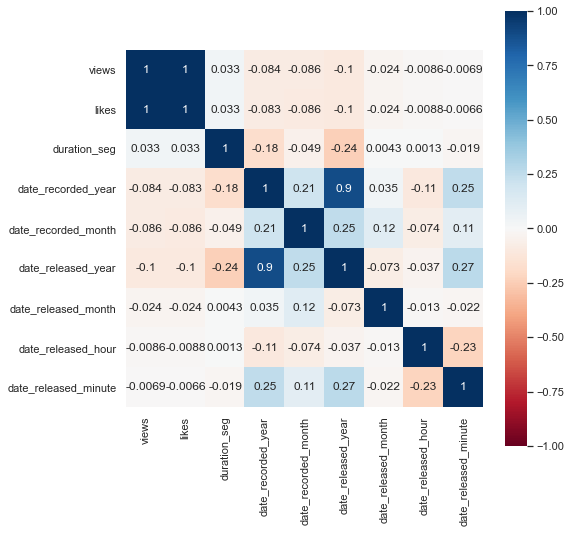

In [783]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_graph.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

In [784]:
# analyzing keywords

In [785]:
dummy_columns=pd.Series(np.arange(15,349,1))[1:]
df_d=pd.concat([df.iloc[:,dummy_columns],df[['likes', 'views', 'date_released_month']]], axis=1)
df_d.head(3)

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',likes,views,date_released_month
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12000,404000,2
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,6400,214000,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12000,412000,2


In [786]:
df_d.shape

(5440, 336)

## Exploring: Keywords categories

In [787]:
df_dummies=main()[1]
df_dummies.head(3)

,categories,keywords,sum
0,technology,'3dprinting',9
1,values & emotions,'activism',352
2,health,'addiction',20


In [788]:
df_dummies=df_dummies.sort_values(by='categories').reset_index().drop('index', axis=1)
df_dummies.head(5)

,categories,keywords,sum
0,art,'animation',713
1,art,'dance',54
2,art,'theater',24
3,art,'painting',33
4,art,'sports',75


           categories   sum
0              health  9630
1             society  8549
2          technology  4376
3             science  3080
4                 art  2230
5              global  2023
6               other  1818
7         environment  1815
8           education  1691
9             culture  1546
10  values & emotions  1347
11    personal growth  1259
12           business  1175
13            climate  1133
14           religion   140


<AxesSubplot:xlabel='categories', ylabel='sum'>

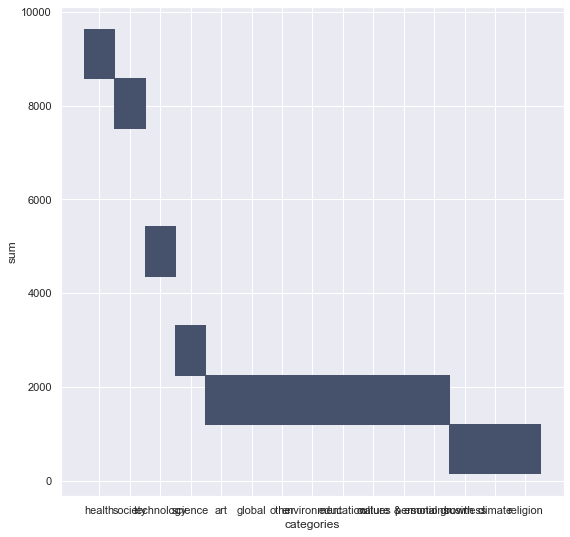

In [789]:
df_graph=(
            (df_dummies.groupby(['categories'])['sum'].sum().reset_index())
            .sort_values(['sum'],ascending=[False]).reset_index()
).drop('index', axis=1)
print(df_graph)

sns.histplot(data=df_graph, x='categories', y='sum',shrink=.8)

           categories   sum  rand_x  rand_y
0              health  9630       7       4
1             society  8549       1       7
2          technology  4376       6       9
3             science  3080       5       9
4                 art  2230       6       7
5              global  2023       1       1
6               other  1818       6       8
7         environment  1815       0       3
8           education  1691       1       4
9             culture  1546       7       2
10  values & emotions  1347       3       5
11    personal growth  1259       5       4
12           business  1175       6       5
13            climate  1133       6       8
14           religion   140       8       8


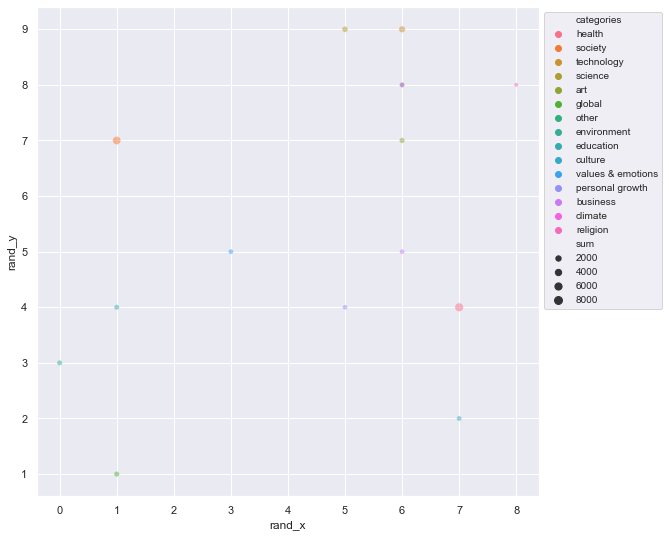

In [790]:
df_graph=(
            (df_dummies.groupby(['categories'])['sum'].sum().reset_index())
            .sort_values(['sum'],ascending=[False]).reset_index()
).drop('index', axis=1)

df_graph['rand_x']=np.random.randint(0,10,size=(15, 1))
df_graph['rand_y']=np.random.randint(0,10,size=(15, 1))
print(df_graph)

sns.scatterplot(data=df_graph, x="rand_x", y="rand_y", size="sum", legend=True, hue='categories', alpha=0.5) 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
sns.set(rc={"figure.figsize":(9 , 9)}) #(width,height)
plt.show()

# ML Predicting model for likes based on content labels to answer:
Will certain labels increase the likes on a content

In [791]:
# #what constitude a good video based on likes?
y=1000
df_graph=df.likes.apply(lambda x: round(x/y,0))
df_graph.describe()

count    5440.000000
mean       62.666912
std       107.730958
min         0.000000
25%        20.000000
50%        41.000000
75%        65.000000
max      2100.000000
Name: likes, dtype: float64

In [792]:
df[df.likes.isnull()==True]

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'


In [793]:
#create target

#we define a well performing video if it is above 75% percentile
threshold= np.percentile(df_d.likes, 75)

#create target column
df_d['target']=[1 if x>threshold else 0 for x in df.likes]

In [794]:
#drop multicolinearity columns
df_d=df_d.drop(['likes', 'views'], axis=1)

In [795]:
data=df_d.copy()
data.head(3)

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'typography','unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',date_released_month,target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [796]:
#Balance data
data.target.value_counts()

0    4098
1    1342
Name: target, dtype: int64

In [797]:
positive_labels = data[data.target==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

1342

In [798]:
negative_labels = data[data.target==0].sample(num_positive_labels)
negative_labels.shape

(1342, 335)

In [799]:
balanced_data =  positive_labels.append(negative_labels)
balanced_data.target.value_counts()

1    1342
0    1342
Name: target, dtype: int64

In [800]:
## Splitting data into test splits

In [801]:
y = balanced_data.pop('target')
X = balanced_data

In [802]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.head()

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'trust','typography','unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',date_released_month
2767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
5176,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
3113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## Fitting Model

In [803]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

/Users/alialvarez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

In [804]:
# Predict probabilities given test data
y_pred = clf.predict_proba(X_test)

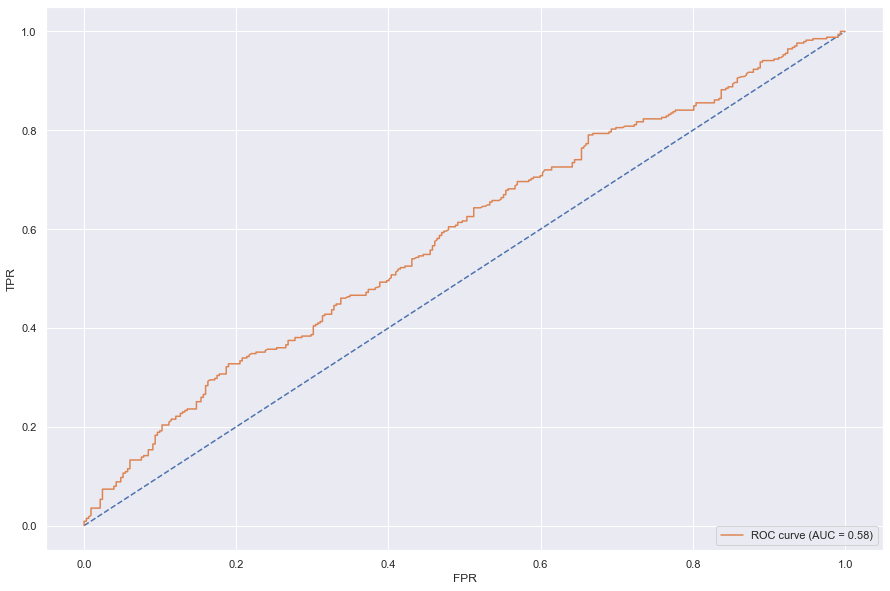

In [805]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

In [806]:
clf.coef_[0]

array([ 3.10063718e-01, -5.77593080e-02, -6.80611643e-01, -8.62458108e-01,
       -1.38652875e-02,  1.02289746e-01,  3.92529097e-01, -4.14698979e-01,
        3.54308922e-01,  1.71852339e-01,  1.06140996e-01,  2.92171461e-01,
       -6.56822719e-01,  7.19022071e-01,  2.82003327e-01, -1.27655100e-02,
       -1.02181847e+00, -5.91584845e-02, -3.49403589e-01,  1.83146238e+00,
        6.17383975e-01, -5.89721879e-01,  5.06349469e-01,  3.88683105e-01,
        2.61899737e-01,  0.00000000e+00,  1.23729764e-01, -4.59972183e-01,
        5.64441706e-01, -7.28743995e-01,  6.11251797e-01, -1.51003851e-01,
        6.03763337e-02, -3.59505406e-02, -8.92307929e-01,  9.20163639e-02,
        4.52794323e-01,  3.58724819e-01, -1.79224194e-01, -1.72855575e-01,
       -1.28561204e-01, -2.11367650e-01,  4.32515469e-01,  8.40333023e-01,
       -1.51390760e-01,  1.50012514e-01,  5.85371784e-01,  3.17858339e-03,
       -1.21507266e-01,  3.07843935e-01,  2.79428568e-01,  4.33246111e-01,
       -6.45641679e-02,  

## Feature Importance

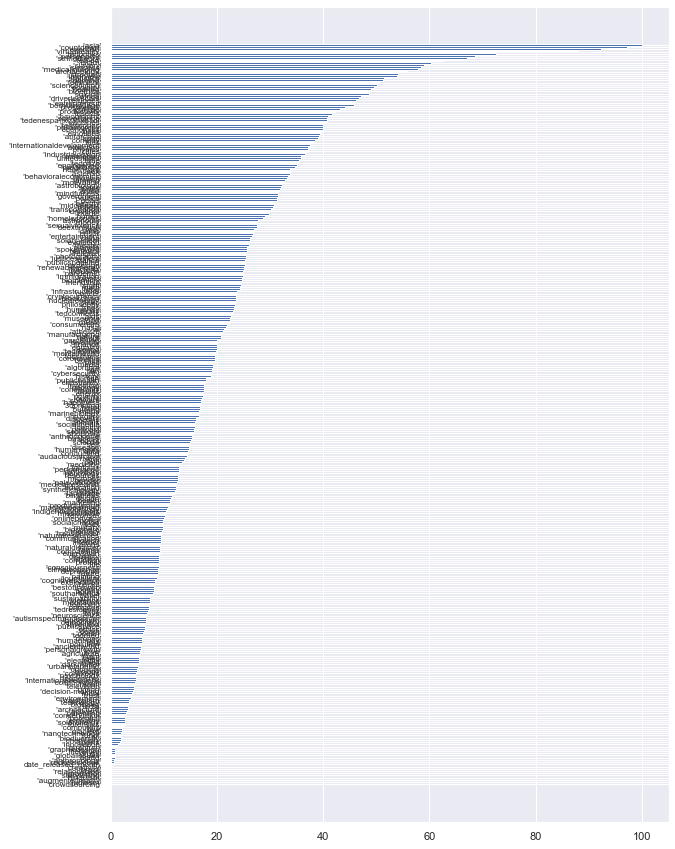

In [807]:
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()

In [808]:
# NLP Machine Learning on Description

# Analysis

In [809]:
# #what constitude a good video based on views?
y=1000
df_graph=df.views.apply(lambda x: round(x/y,0))
df_graph.describe()

count     5440.000000
mean      2063.652941
std       3569.598818
min          1.000000
25%        670.750000
50%       1300.000000
75%       2100.000000
max      72000.000000
Name: views, dtype: float64

### Top 10 Liked Videos

In [810]:
#build data: These are the 75% most liked videos
y_var='likes'
df_grap = (
    (df.groupby(['title','author','date_recorded_year','views'])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index()
df_grap=df_grap.drop('index', axis=1)
df_grap = df_grap[df_grap[y_var] > 65000]
df_grap

,title,author,date_recorded_year,views,likes
0,Do schools kill creativity?,Sir Ken Robinson,2006,72000000,2100000
1,The self-organizing computer course,Amy Cuddy,2012,64000000,1900000
2,Inside the mind of a master procrastinator,Tim Urban,2016,60000000,1800000
3,The power of vulnerability,Brené Brown,2010,56000000,1700000
4,How great leaders inspire action,Simon Sinek,2009,57000000,1700000
...,...,...,...,...,...
1338,Why elephants never forget,Leana Wen,2014,2200000,66000
1339,What if we digitally empowered community healt...,Hugh Herr,2018,2200000,66000
1340,Why elephants never forget,Alejandro Aravena,2014,2200000,66000
1341,How humanity can reach the stars,Laurence Hurst,2020,2200000,66000


In [811]:
#This is taking the 75% percentile on liked videos
#Modifiable variables
y_var='likes'

#build data
df_grap = (
    (df.groupby(['title','author','date_recorded_year','views'])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index()
df_grap=df_grap.drop('index', axis=1)
df_grap = df_grap[df_grap[y_var] > 65000]
df_grap.head(30)

,title,author,date_recorded_year,views,likes
0,Do schools kill creativity?,Sir Ken Robinson,2006,72000000,2100000
1,The self-organizing computer course,Amy Cuddy,2012,64000000,1900000
2,Inside the mind of a master procrastinator,Tim Urban,2016,60000000,1800000
3,The power of vulnerability,Brené Brown,2010,56000000,1700000
4,How great leaders inspire action,Simon Sinek,2009,57000000,1700000
5,How to speak so that people want to listen,Julian Treasure,2013,49000000,1400000
6,The next outbreak? We're not ready,Bill Gates,2015,43000000,1300000
7,My philosophy for a happy life,Sam Berns,2013,43000000,1300000
8,What makes a good life? Lessons from the longe...,Robert Waldinger,2015,41000000,1200000
9,Why people believe they can't draw,Graham Shaw,2015,37000000,1100000


### Top 10 Authors

In [812]:
#Modifiable variables
y_var='views'
x_var1='author'
x_var2='likes'

#build data
df_grap = (
    (df.groupby([x_var1, x_var2])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index().head(10)
df_grap=df_grap.drop('index', axis=1)
df_grap

,author,likes,views
0,Sir Ken Robinson,2100000,72000000
1,Amy Cuddy,1900000,64000000
2,Tim Urban,1800000,60000000
3,Simon Sinek,1700000,57000000
4,Brené Brown,1700000,56000000
5,Julian Treasure,1400000,49000000
6,Bill Gates,1300000,43000000
7,Sam Berns,1300000,43000000
8,Robert Waldinger,1200000,41000000
9,Cameron Russell,1100000,38000000


In [813]:
# #visualize
# x_var='author'
# y_var='views'
# sns.set_theme(style="white")
# ax = sns.barplot(x=y_var, y=x_var, data=df_grap, orient="h")

In [814]:
# #visualize
# x_var='author'
# y_var='likes'
# sns.set_theme(style="white")
# ax = sns.barplot(x=y_var, y=x_var, data=df_grap, orient="h", palette="Blues_d")

In [815]:
#from pandasql import sqldf
# q = """
# SELECT
# `title`
# FROM
# df
# LIMIT 5
# """
# print(sqldf(q))

Areas of improvements:
    
    1) More information on the authors. Understanding age, gender and nationality of authors, may answer questions related to diversity of the speakers. This data could be parcially scrapped from Wikipedia as there is a dedicated website that tracks this information. 
    https://en.wikipedia.org/wiki/List_of_TED_speakers